In [14]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sb

# Nodes

Each node contains the following properties:

● name: A description of the node. 

● prevalence​: The relative prevalence of the node in the underlying inventory.

● x​: A projected x-coordinate from a force-directed simulation in a Cartesian space.

● y​: A projected y-coordinate from a force-directed simulation in a Cartesian space.

# Links

Each link contains the following properties:

● source​: Index of the source node in the node list.

● target​: Index of the target/destination node in the node list.

● value​: The weight of the edge connecting the source and target nodes.


In [30]:
with open("/Users/codywebb/Downloads/graph.json") as f:
    data = json.load(f)

nodes = pd.DataFrame(data["nodes"])
links = pd.DataFrame(data["links"])

#nodes['index'] = nodes.index

print(nodes.head())
print('\n')
print(links.head())

                 name  prevalence         x         y
0          Bill Maher      1.0000  -85.1569 -137.9791
1         John Oliver      0.9730  268.7907   57.8283
2       United States      0.8595   36.1653 -194.3289
3    Tyrion Lannister      0.8595  179.9301 -253.6939
4  Daenerys Targaryen      0.7730  178.8628 -255.9866


   source  target   value
0      13       0  0.6698
1     187       0  0.7381
2     285       0  1.0000
3     287       0  1.0000
4      36       1  1.0000


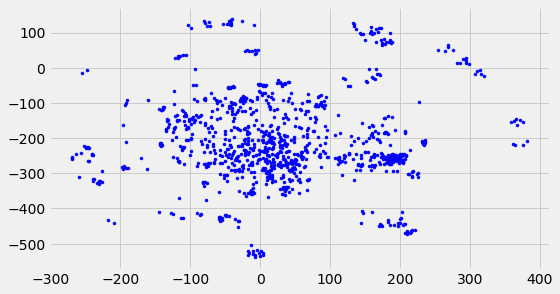

In [25]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()

ax.scatter(nodes['x'], nodes['y'], color = 'blue', marker = '.')

fig.set_size_inches(8, 4.5)

plt.show()

# Defining relevance between two connected objects:

If there are two quantities $A_1$ and $A_2$, with prevalences $p_1$ and $p_2$ and a value between them of $w_{1_2}$, then I'll define relevance as 
$p_1 * p_2 * w_{1_2}$.


In [33]:
relevance_list = []

for i in range(len(links)): 
    source = links['source'][i]
    target = links['target'][i]

    ps = nodes['prevalence'][source]
    pt = nodes['prevalence'][target]
    value = links['value'][i]

    relevance = ps * pt * value
    relevance_list.append(relevance)
    
links['relevance'] = relevance_list

print(links.head())

   source  target   value  relevance
0      13       0  0.6698   0.383795
1     187       0  0.7381   0.167549
2     285       0  1.0000   0.167600
3     287       0  1.0000   0.189200
4      36       1  1.0000   0.478619


# Clustering Algorithm

Then I will create a $k$-means clustering algorithm to find the neighborhoods based on the distance metrics divided earlier. 

I will perform $k$-means clustering with $k$ ranging from 1 to 20 to see which best represents the underlying data. 


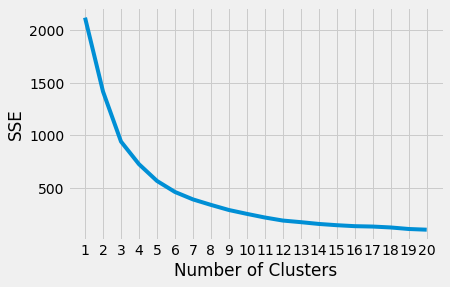

In [34]:
loc_array = nodes[['x', 'y']].to_numpy()
idx_array = np.array(range(len(nodes)))

scaler = StandardScaler() #Normalize the data.
scaled_locs = scaler.fit_transform(loc_array)

kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}

sse = []

# Run the k-means algorithm for values of k in [1,20].

for k in range(1,21):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_locs)
    sse.append(kmeans.inertia_)

    
# Plot the inertia values and see if the inflection point is visible.
plt.plot(range(1,21), sse)
plt.xticks(range(1, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# Neighborhoods

Based on the SSE graph, 7 seems like the correct number of neighborhoods for this data. It might be 6 or 8, but it's still close enough that it should be valid. 

Now I will label the data based on what cluster they are supposedly in to see if the data seems to match the assignment.

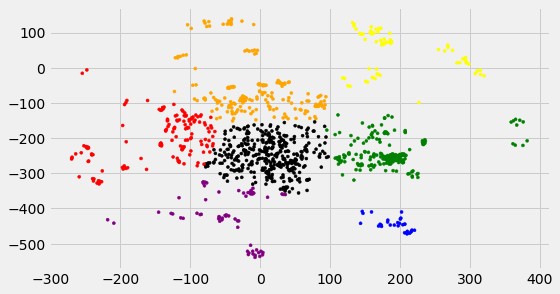

In [48]:
kmeans = KMeans(init = "random", n_clusters = 7, n_init = 10, 
                max_iter = 300, random_state = 42)

kmeans.fit(scaled_locs)

labels = list(kmeans.labels_)
nodes['label'] = labels

colors = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue', 5: 'purple', 6: 'black'}
fig, ax = plt.subplots()

ax.scatter(nodes['x'], nodes['y'], c=nodes['label'].map(colors), marker = '.')

fig.set_size_inches(8, 4.5)

plt.show()

# Best Neighborhoods

I want to find the top three neighborhoods of the seven available. To do that, I will see which ones have the most relevant connections per capita. Using the relevance metric that was defined earlier, I will see which neighborhoods have the most relevant connections per capita. If a connection is inter-neighborhood, it will be ignored. 

The final value for each neighborhood will be:

(Sum of all intra-neighborhood relevance scores for that neighborhood) / (# of things in that neighborhood)

The neighborhoods with the largest values will be considered "best".

In [58]:
links['target_label'] = list(nodes['label'][links.target])
links['source_label'] = list(nodes['label'][links.source])

link_neighbors = links[links.target_label == links.source_label]

neighbor_connections = [0 for i in range(7)]
neighborhood_size = [0 for i in range(7)]

for i in links.index:
    neighbor_connections[links['target_label'][i]] += links['relevance'][i]
    
for i in nodes.index:
    neighborhood_size[nodes['label'][i]] += 1
    
total_relevance_dict = {}    

for i in range(7):
    total_relevance_dict[i] = neighbor_connections[i] / neighborhood_size[i] 

final_vals = {k: v for k, v in sorted(total_relevance_dict.items(), key=lambda item: item[1], reverse= True)}

print('Cluster: \t Relevance Value: \n')
for key in final_vals.keys():
    print(str(key) + '\t\t    ' + format(final_vals[key], '.4f'))
    print("-" * 30 + "\n")

Cluster: 	 Relevance Value: 

3		    0.4732
------------------------------

1		    0.2508
------------------------------

6		    0.1707
------------------------------

0		    0.0947
------------------------------

2		    0.0620
------------------------------

5		    0.0620
------------------------------

4		    0.0524
------------------------------



# Conclusion:

Based on the way I defined relevance, the three best neighborhoods are cluster 3, cluster 1, and cluster 6.

In [70]:
print("Most Prevalent of Cluster 3:")
print(nodes[nodes['label'] == 3][['name', 'prevalence', 'label']].sort_values(by = 'prevalence', ascending = False).head())
print('\n')

print("Most Prevalent of Cluster 1:")
print(nodes[nodes['label'] == 1][['name', 'prevalence', 'label']].sort_values(by = 'prevalence', ascending = False).head())
print('\n')

print("Most Prevalent of Cluster 6:")
print(nodes[nodes['label'] == 6][['name', 'prevalence', 'label']].sort_values(by = 'prevalence', ascending = False).head())

Most Prevalent of Cluster 3:
                 name  prevalence  label
3    Tyrion Lannister      0.8595      3
4  Daenerys Targaryen      0.7730      3
5      Peter Dinklage      0.7459      3
6         Lena Headey      0.7405      3
8    Cersei Lannister      0.6703      3


Most Prevalent of Cluster 1:
                    name  prevalence  label
13           Los Angeles      0.5730      1
21              Jon Hamm      0.5297      1
38         January Jones      0.4865      1
40   Christina Hendricks      0.4811      1
41        Elisabeth Moss      0.4811      1


Most Prevalent of Cluster 6:
                    name  prevalence  label
2          United States      0.8595      6
7   Sarah Jessica Parker      0.7027      6
12         Gabriel Byrne      0.5892      6
14         New York City      0.5459      6
15          Jeremy Piven      0.5351      6
